In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress, skew, kurtosis
from scipy.signal import find_peaks
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import display, clear_output
import ast

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the datasets
metadata = pd.read_csv("C:\\Users\\Zeeshan\\Desktop\\TA\\data (book popularity)\\data\\SPGC-metadata-2018-07-18.csv")
kld_scores = pd.read_csv("C:\\Users\\Zeeshan\\Desktop\\TA\\data (book popularity)\\data\\KLDscores.csv")
extra_controls = pd.read_csv("C:\\Users\\Zeeshan\\Desktop\\TA\\data (book popularity)\\data\\extra_controls.csv")

In [3]:
# Display the first few rows of each dataset to understand their structure
metadata.head(), kld_scores.head(), extra_controls.head()

(    id                                              title  \
 0  PG0                                                NaN   
 1  PG1  The Declaration of Independence of the United ...   
 2  PG2  The United States Bill of Rights: The Ten Orig...   
 3  PG3                John F. Kennedy's Inaugural Address   
 4  PG4  Lincoln's Gettysburg Address: Given November 1...   
 
                                author  authoryearofbirth  authoryearofdeath  \
 0                                 NaN                NaN                NaN   
 1                   Jefferson, Thomas             1743.0             1826.0   
 2                       United States                NaN                NaN   
 3  Kennedy, John F. (John Fitzgerald)             1917.0             1963.0   
 4                    Lincoln, Abraham             1809.0             1865.0   
 
   language  downloads                                           subjects  type  
 0      NaN        NaN                                        

The below code chucnk performs several data cleaning steps, such as renaming columns,
handling missing values and converting data type.

Finally at the end we mearge the three datasets into one.


In [12]:
# Data Cleaning
# Rename columns for consistency
metadata.rename(columns={'id': 'book_id'}, inplace=True)
kld_scores.rename(columns={'filename': 'book_id'}, inplace=True)
extra_controls.rename(columns={'id': 'book_id'}, inplace=True)

# Drop rows with missing book_id or downloads
metadata.dropna(subset=['book_id', 'downloads'], inplace=True)

# Fill missing values for author details with a placeholder
metadata['author'].fillna('Unknown', inplace=True)
metadata['authoryearofbirth'].fillna(0, inplace=True)
metadata['authoryearofdeath'].fillna(0, inplace=True)

# Convert columns to appropriate data types in metadata
metadata['downloads'] = metadata['downloads'].astype(int)
metadata['authoryearofbirth'] = metadata['authoryearofbirth'].astype(int)
metadata['authoryearofdeath'] = metadata['authoryearofdeath'].astype(int)

# Drop rows with missing book_id or KLD scores
kld_scores.dropna(subset=['book_id', 'kld_values'], inplace=True)

# Fill missing values with 0 for numerical columns
extra_controls.fillna(0, inplace=True)

# Ensure all columns except 'book_id' are numerical in extra_controls
for col in extra_controls.columns:
    if col != 'book_id':
        extra_controls[col] = pd.to_numeric(extra_controls[col], errors='coerce')
extra_controls.fillna(0, inplace=True)  # Refill any NaNs introduced by coercion

# Inspect data types
print(metadata.dtypes)
print(kld_scores.dtypes)
print(extra_controls.dtypes)

# Merge metadata, KLD characteristics, and extra controls
merged_data = metadata.merge(kld_scores, on='book_id').merge(extra_controls, on='book_id')


book_id              object
title                object
author               object
authoryearofbirth     int32
authoryearofdeath     int32
language             object
downloads             int32
subjects             object
type                 object
dtype: object
book_id       object
kld_values    object
dtype: object
book_id                  object
subj2_war                 int64
subj2_adventure           int64
subj2_comedy              int64
subj2_biography           int64
subj2_romance             int64
subj2_drama               int64
subj2_fantasy             int64
subj2_family              int64
subj2_sciencefiction      int64
subj2_action              int64
subj2_thriller            int64
subj2_western             int64
subj2_horror              int64
subj2_mystery             int64
subj2_crime               int64
subj2_history             int64
subj2_periodicals         int64
subj2_others              int64
speed                   float64
sentiment_avg           float64
sentim

In [13]:
# Convert kld_values from string to list of floats
def parse_kld_values(kld_string):
    return list(map(float, ast.literal_eval(kld_string)))

merged_data['kld_values'] = merged_data['kld_values'].apply(parse_kld_values)
metadata['downloads'] = metadata['downloads'].astype(int)

# Inspect the merged data
print(merged_data.head())
print(merged_data.info())


  book_id                             title                 author  \
0    PG79               Terminal Compromise        Schwartau, Winn   
1   PG102  The Tragedy of Pudd'nhead Wilson            Twain, Mark   
2   PG105                        Persuasion           Austen, Jane   
3   PG106            Jungle Tales of Tarzan  Burroughs, Edgar Rice   
4   PG107        Far from the Madding Crowd          Hardy, Thomas   

   authoryearofbirth  authoryearofdeath language  downloads  \
0                  0                  0   ['en']         21   
1               1835               1910   ['en']        677   
2               1775               1817   ['en']       2778   
3               1875               1950   ['en']        225   
4               1840               1928   ['en']        555   

                                            subjects  type  \
0  {'Computer security -- Fiction', 'Didactic fic...  Text   
1  {'Trials (Murder) -- Fiction', 'Impostors and ...  Text   
2  {'Regency f

In [6]:
# Save the merged data to a CSV file
merged_data.to_csv("C:\\Users\\Zeeshan\\Desktop\\TA\\data (book popularity)\\data\\merged_data.csv", index=False)

Below I created a function called generate_kld_features to extract useful statistics from the KLD values for each book. This function calculates the average (mean), variance, trend slope, skewness, kurtosis, and the number of peaks in the KLD values. I then applied this function to each book's KLD values in the dataset using the apply method. The results were added as new columns (avg_kld, var_kld, slope_kld, skewness_kld, kurtosis_kld, num_peaks_kld) to the merged_data DataFrame, which gives us more detailed information to analyze how these KLD characteristics relate to the book's popularity.

In [7]:
# Generate new features from KLD values
def generate_kld_features(kld_values):
    kld_array = np.array(kld_values)
    avg_kld = np.mean(kld_array)
    var_kld = np.var(kld_array)
    trend_slope, trend_intercept, _, _, _ = linregress(range(len(kld_array)), kld_array)
    skewness_kld = skew(kld_array)
    kurtosis_kld = kurtosis(kld_array)
    peaks, _ = find_peaks(kld_array)
    num_peaks_kld = len(peaks)
    return avg_kld, var_kld, trend_slope, skewness_kld, kurtosis_kld, num_peaks_kld

merged_data[['avg_kld', 'var_kld', 'slope_kld', 'skewness_kld', 'kurtosis_kld', 'num_peaks_kld']] = merged_data['kld_values'].apply(
    lambda x: pd.Series(generate_kld_features(x))
)



I ensured the dataset was clean by handling any infinite or missing (NaN) values. First, I replaced any occurrences of positive or negative infinity (np.inf, -np.inf) with NaN, and then I removed all rows containing NaN values using the dropna method. To make the downloads data more suitable for regression analysis and to address potential issues with zero values, I applied a log transformation to the downloads column. By adding 1 before taking the logarithm, I ensured that there were no problems with taking the log of zero, which is undefined. This transformation helps to stabilize the variance and normalize the distribution of the downloads data.

In [8]:
# Handle inf and NaN values
merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_data.dropna(inplace=True)

# Log transform the downloads column
merged_data['log_downloads'] = np.log(merged_data['downloads'] + 1)  # Add 1 to avoid log(0)


In [9]:
merged_data

,book_id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type,kld_values,...,sentiment_avg,sentiment_vol,wordcount,avg_kld,var_kld,slope_kld,skewness_kld,kurtosis_kld,num_peaks_kld,log_downloads
0,PG79,Terminal Compromise,"Schwartau, Winn",0,0,['en'],21,"{'Computer security -- Fiction', 'Didactic fic...",Text,"[0.2757379259625541, 0.24798943716089544, 0.27...",...,0.12578,0.007630,209058.0,0.241195,0.000512,-0.000390,0.778366,1.357141,14.0,3.091042
1,PG102,The Tragedy of Pudd'nhead Wilson,"Twain, Mark",1835,1910,['en'],677,"{'Trials (Murder) -- Fiction', 'Impostors and ...",Text,"[0.279944221642895, 0.2578040453491282, 0.2843...",...,0.13318,0.004250,52465.0,0.278951,0.002585,0.000474,1.397116,2.060044,18.0,6.519147
2,PG105,Persuasion,"Austen, Jane",1775,1817,['en'],2778,"{'Regency fiction', 'Ship captains -- Fiction'...",Text,"[0.216724940056036, 0.2165917910773945, 0.2422...",...,0.16867,0.005280,82944.0,0.229130,0.000532,0.000048,1.508529,3.563027,13.0,7.929846
3,PG106,Jungle Tales of Tarzan,"Burroughs, Edgar Rice",1875,1950,['en'],225,"{'Tarzan (Fictitious character) -- Fiction', '...",Text,"[0.21957989250542345, 0.20715649423990418, 0.2...",...,0.10250,0.004305,73714.0,0.231686,0.000480,-0.000079,1.671049,4.457829,14.0,5.420535
4,PG107,Far from the Madding Crowd,"Hardy, Thomas",1840,1928,['en'],555,"{'Love stories', 'Wessex (England) -- Fiction'...",Text,"[0.22957419343700353, 0.20965547352173658, 0.2...",...,0.12513,0.007081,136528.0,0.228993,0.000455,0.000087,0.596233,-0.053075,18.0,6.320768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8544,PG56752,Double Play: A Story of School and Baseball,"Barbour, Ralph Henry",1870,1944,['en'],18,"{'Baseball -- Juvenile fiction', 'Baseball sto...",Text,"[0.23726776508309688, 0.25779721452897975, 0.2...",...,0.14420,0.004134,67219.0,0.253683,0.001202,0.000218,1.348606,3.447070,15.0,2.944439
8545,PG56870,Tales from Gorky,"Gorky, Maksim",1868,1936,['en'],50,"{'Short stories, Russian -- Translations into ...",Text,"[0.22650213276975628, 0.25882154623059206, 0.2...",...,0.13157,0.004209,63467.0,0.245178,0.001656,0.000038,2.392328,6.664034,14.0,3.931826
8546,PG57137,"Barry Wynn: Or, The Adventures of a Page Boy i...","Barton, George",1866,1940,['en'],66,{'Capitol pages -- Fiction'},Text,"[0.26118043436857097, 0.2377733306258158, 0.22...",...,0.14581,0.004023,55711.0,0.246141,0.001605,0.000364,1.458144,2.008887,13.0,4.204693
8547,PG57166,Just a Girl,"Garvice, Charles",1850,1920,['en'],61,{'English fiction -- 19th century'},Text,"[0.23684874296548403, 0.23642848573061798, 0.2...",...,0.15964,0.009051,144734.0,0.222184,0.000397,-0.000456,0.873179,1.285610,14.0,4.127134


In [10]:
# Select relevant columns for the final dataset
final_columns = ['book_id', 'title', 'author', 'downloads', 'language', 'type', 'speed', 'sentiment_avg', 'sentiment_vol', 'wordcount',
                 'avg_kld', 'var_kld', 'slope_kld', 'skewness_kld', 'kurtosis_kld', 'num_peaks_kld']
subj2_columns = [col for col in extra_controls.columns if col.startswith('subj2_')]
final_columns.extend(subj2_columns)
final_data = merged_data[final_columns]

# Select relevant columns for the final dataset
final_columns = ['book_id', 'title', 'author', 'subject_genre', 'downloads', 'language', 'type', 'speed', 'sentiment_avg', 'sentiment_vol', 'wordcount',
                 'avg_kld', 'var_kld', 'slope_kld', 'skewness_kld', 'kurtosis_kld', 'num_peaks_kld']
final_data = merged_data[final_columns]

In [14]:
final_data

,book_id,title,author,downloads,language,type,speed,sentiment_avg,sentiment_vol,wordcount,...,subj2_sciencefiction,subj2_action,subj2_thriller,subj2_western,subj2_horror,subj2_mystery,subj2_crime,subj2_history,subj2_periodicals,subj2_others
0,PG79,Terminal Compromise,"Schwartau, Winn",21,['en'],Text,0.171519,0.12578,0.007630,209058.0,...,0,0,0,0,0,0,0,0,0,1
1,PG102,The Tragedy of Pudd'nhead Wilson,"Twain, Mark",677,['en'],Text,0.248672,0.13318,0.004250,52465.0,...,0,0,0,0,0,0,0,0,0,1
2,PG105,Persuasion,"Austen, Jane",2778,['en'],Text,0.175747,0.16867,0.005280,82944.0,...,0,0,0,0,0,0,0,0,0,0
3,PG106,Jungle Tales of Tarzan,"Burroughs, Edgar Rice",225,['en'],Text,0.209854,0.10250,0.004305,73714.0,...,0,0,0,0,0,0,0,0,0,0
4,PG107,Far from the Madding Crowd,"Hardy, Thomas",555,['en'],Text,0.167575,0.12513,0.007081,136528.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8544,PG56752,Double Play: A Story of School and Baseball,"Barbour, Ralph Henry",18,['en'],Text,0.229725,0.14420,0.004134,67219.0,...,0,0,0,0,0,0,0,0,0,1
8545,PG56870,Tales from Gorky,"Gorky, Maksim",50,['en'],Text,0.218492,0.13157,0.004209,63467.0,...,0,0,0,0,0,0,0,0,0,1
8546,PG57137,"Barry Wynn: Or, The Adventures of a Page Boy i...","Barton, George",66,['en'],Text,0.221373,0.14581,0.004023,55711.0,...,0,0,0,0,0,0,0,0,0,1
8547,PG57166,Just a Girl,"Garvice, Charles",61,['en'],Text,0.162528,0.15964,0.009051,144734.0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
# Save the final dataset to a CSV file
final_data.to_csv("C:\\Users\\Zeeshan\\Desktop\\TA\\data (book popularity)\\data\\final_data.csv", index=False)


In [17]:
# Descriptive statistics
print(final_data.describe())

          downloads        speed  sentiment_avg  sentiment_vol     wordcount  \
count   8549.000000  8549.000000    8549.000000    8549.000000  8.549000e+03   
mean      72.516435     0.197259       0.135845       0.005365  9.434481e+04   
std      524.030945     0.027944       0.023470       0.001973  7.053532e+04   
min        0.000000     0.000000       0.000000       0.000000  0.000000e+00   
25%       10.000000     0.180287       0.120100       0.004097  6.248500e+04   
50%       17.000000     0.199056       0.135210       0.005008  7.988300e+04   
75%       36.000000     0.216786       0.150500       0.006223  1.068820e+05   
max    31755.000000     0.389963       0.248720       0.043114  2.557965e+06   

           avg_kld      var_kld    slope_kld  skewness_kld  kurtosis_kld  ...  \
count  8549.000000  8549.000000  8549.000000   8549.000000   8549.000000  ...   
mean      0.239545     0.001180     0.000319      1.893951      6.543371  ...   
std       0.013488     0.001020     

To focus on the numerical data for analysis, I first excluded any non-numeric columns from the final_data DataFrame. This was done by selecting only columns with data types of float or int and creating a new DataFrame called numeric_df.

Next, I calculated the correlation matrix for the numerical data. 

In [18]:

# Exclude non-numeric columns
numeric_df = final_data.select_dtypes(include=[float, int])
# Correlation matrix
corr_matrix = numeric_df.corr()
print(corr_matrix)

                      downloads     speed  sentiment_avg  sentiment_vol  \
downloads              1.000000 -0.085079      -0.004137       0.102791   
speed                 -0.085079  1.000000      -0.098017      -0.537516   
sentiment_avg         -0.004137 -0.098017       1.000000       0.382359   
sentiment_vol          0.102791 -0.537516       0.382359       1.000000   
wordcount              0.101209 -0.566834       0.095237       0.701200   
avg_kld               -0.056516  0.670618      -0.116311      -0.237155   
var_kld               -0.047600  0.318642      -0.047682      -0.090842   
slope_kld             -0.063849  0.111255       0.017647      -0.092111   
skewness_kld          -0.054760 -0.064137       0.051487      -0.002921   
kurtosis_kld          -0.048837 -0.098975       0.052239       0.013854   
num_peaks_kld          0.002045  0.042209      -0.017671      -0.042909   
subj2_war              0.006060 -0.016752      -0.123988      -0.042184   
subj2_adventure        0.

C:\Users\Zeeshan\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


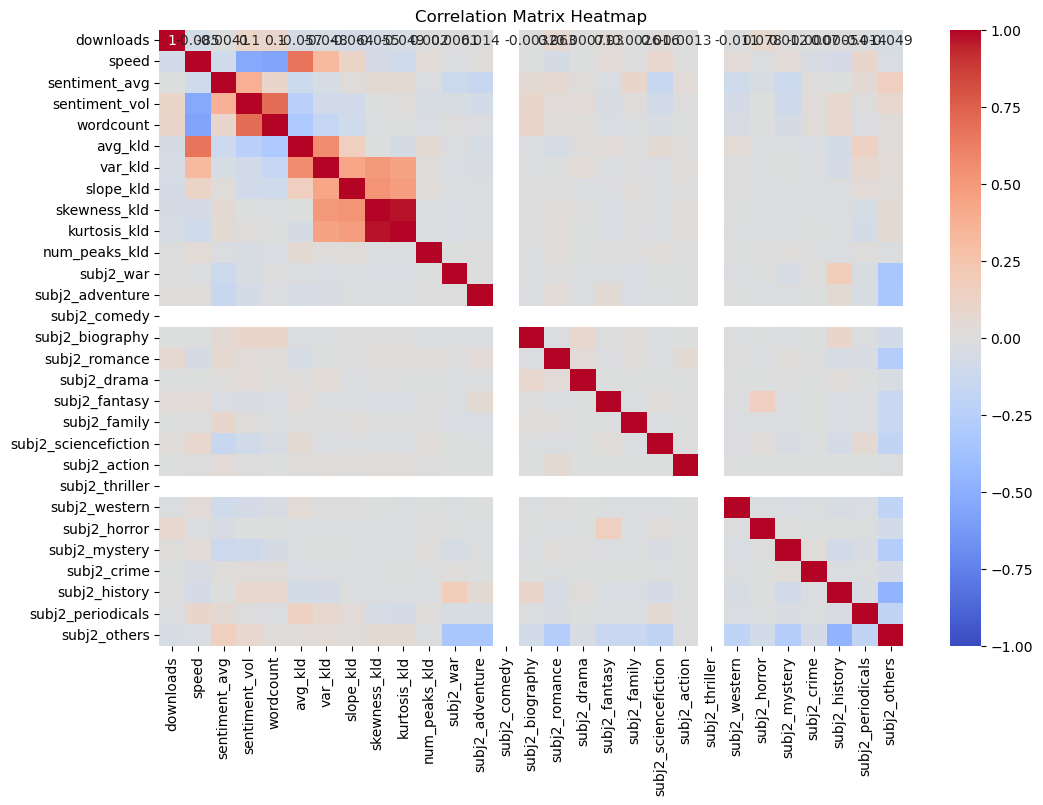

In [19]:
# Heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

Doing correlation matrix for few selected attributes.

Below, I created a heatmap to visualize the correlation matrix of the selected numerical features in our dataset. 
The heatmap provides a visual representation of the strength and direction of the linear relationships between pairs of features.

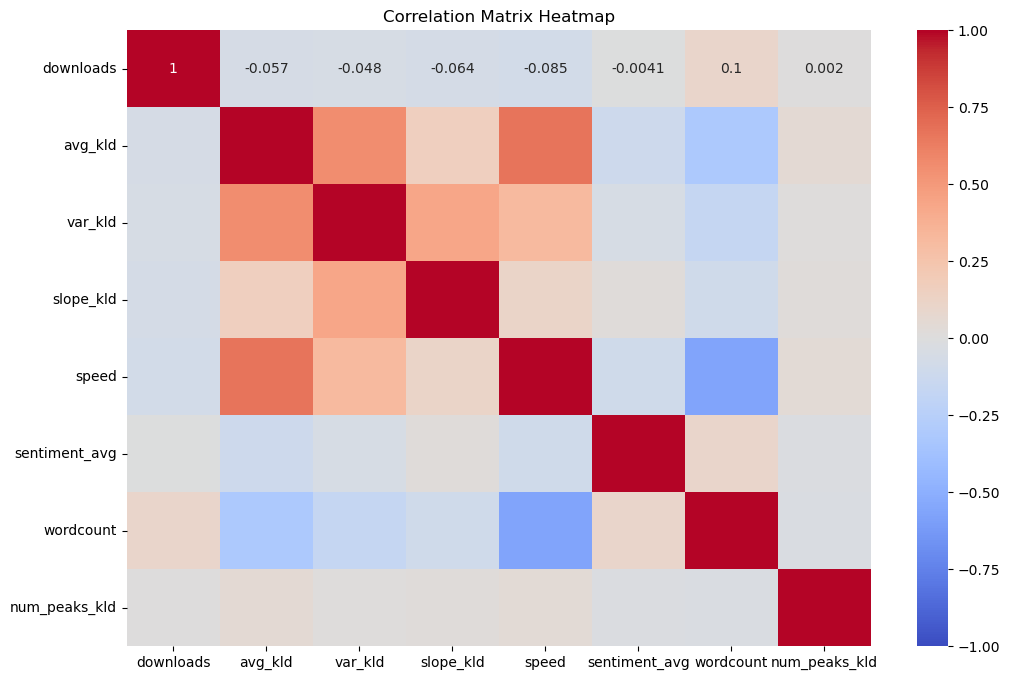

In [20]:
# Select the final list of attributes for analysis
selected_attributes = ['downloads', 'avg_kld', 'var_kld', 'slope_kld', 'speed', 'sentiment_avg', 'wordcount', 'num_peaks_kld']

# Create a DataFrame with selected attributes
df_selected = numeric_df[selected_attributes]

# Correlation matrix
corr_matrix = df_selected.select_dtypes(include=[float, int]).corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

From the above heat wave we can observe that:

1. There are some negative correlations, such as between downloads and avg_kld, var_kld, slope_kld, and speed.
2. There are positive correlations between downloads and wordcount.
3. speed shows a moderate positive correlation with avg_kld and var_kld.

In the code below, I created a scatter plot to visualize the relationship between the average KLD (Kullback-Leibler Divergence) 
and the number of downloads for the books in our dataset.

Each point on the plot corresponds to a book, with its position determined by its average KLD value and the number of downloads.

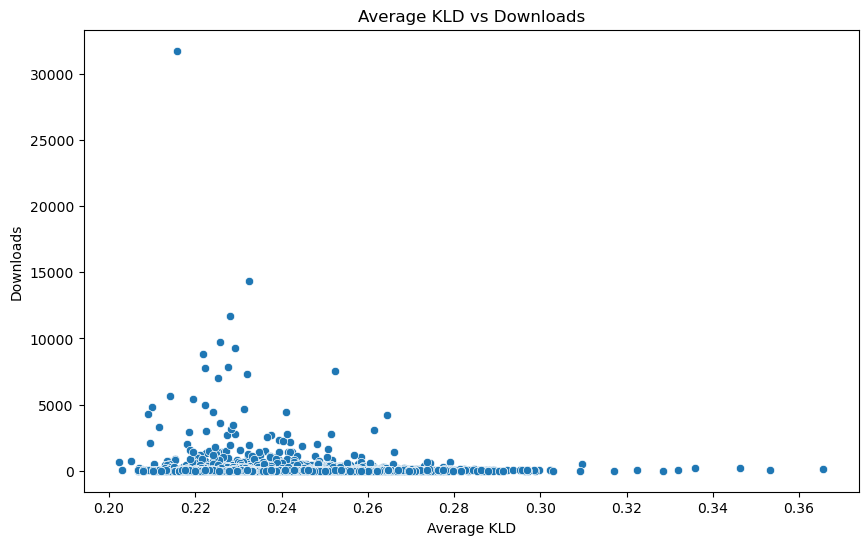

In [21]:
# Scatter plot of avg_kld vs downloads
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_kld', y='downloads', data=df_selected)
plt.title('Average KLD vs Downloads')
plt.xlabel('Average KLD')
plt.ylabel('Downloads')
plt.show()

The scatter plot above helps us to see if there is any correlation between average KLD values and book popularity, as measured by downloads. From the plot, we can observe that there is no clear linear relationship, but most books have average KLD values clustered between 0.20 and 0.26, with a few outliers having much higher download counts. This suggests that while KLD might influence downloads, other factors are also at play.

In the below step, I created a scatter plot to visualize the relationship between Average KLD and Downloads, with the downloads axis on a logarithmic scale.

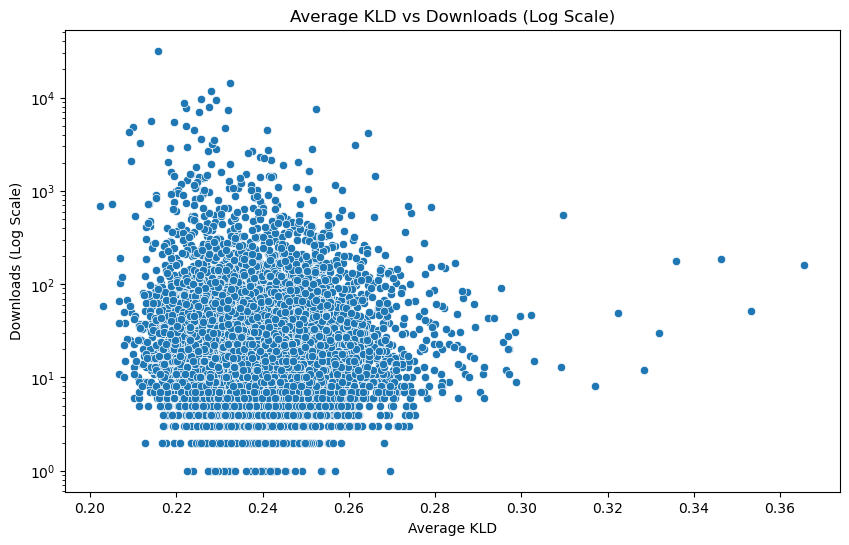

In [22]:
# Scatter plot with logarithmic scale for downloads
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_kld', y='downloads', data=df_selected)
plt.yscale('log')
plt.title('Average KLD vs Downloads (Log Scale)')
plt.xlabel('Average KLD')
plt.ylabel('Downloads (Log Scale)')
plt.show()

By using a logarithmic scale for downloads, we can see the distribution of downloads more clearly, especially where there is a wide range of values. This helps identify patterns or clusters in the data that might not be visible with a linear scale. This visualization provides insight into how the average KLD score of a book might relate to its popularity in terms of downloads.

From the above plot we can see:
1. Most books have an Average KLD value between 0.22 and 0.26.
2. There are several outliers with significantly higher download counts compared to the rest of the data. These outliers are more evident on the log scale, indicating that a few books are exceptionally popular.
3. 


In [23]:
# Print column names to inspect and check data types
print("Column names in the DataFrame:")
print(final_data.columns)

Column names in the DataFrame:
Index(['book_id', 'title', 'author', 'downloads', 'language', 'type', 'speed',
       'sentiment_avg', 'sentiment_vol', 'wordcount', 'avg_kld', 'var_kld',
       'slope_kld', 'skewness_kld', 'kurtosis_kld', 'num_peaks_kld',
       'subj2_war', 'subj2_adventure', 'subj2_comedy', 'subj2_biography',
       'subj2_romance', 'subj2_drama', 'subj2_fantasy', 'subj2_family',
       'subj2_sciencefiction', 'subj2_action', 'subj2_thriller',
       'subj2_western', 'subj2_horror', 'subj2_mystery', 'subj2_crime',
       'subj2_history', 'subj2_periodicals', 'subj2_others'],
      dtype='object')


In [24]:
# Check data types
print("\nData types in the DataFrame:")
print(final_data.dtypes)


Data types in the DataFrame:
book_id                  object
title                    object
author                   object
downloads                 int32
language                 object
type                     object
speed                   float64
sentiment_avg           float64
sentiment_vol           float64
wordcount               float64
avg_kld                 float64
var_kld                 float64
slope_kld               float64
skewness_kld            float64
kurtosis_kld            float64
num_peaks_kld           float64
subj2_war                 int64
subj2_adventure           int64
subj2_comedy              int64
subj2_biography           int64
subj2_romance             int64
subj2_drama               int64
subj2_fantasy             int64
subj2_family              int64
subj2_sciencefiction      int64
subj2_action              int64
subj2_thriller            int64
subj2_western             int64
subj2_horror              int64
subj2_mystery             int64
subj2_crim

In this we selected important features for analysis, such as 'avg_kld' and 'speed', and added a constant term to include an intercept in our model.
After that we used the Ordinary Least Squares method to perform regression analysis and printed a summary of the results to understand how these features relate to log-transformed downloads.


In [27]:
# Log-transform the 'downloads' column 
final_data['log_downloads'] = np.log1p(final_data['downloads'])

# Replace any inf values with NaN
final_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
final_data.dropna(subset=['log_downloads'], inplace=True)

# Select the features for regression analysis
features = ['avg_kld', 'var_kld', 'slope_kld', 'speed', 'sentiment_avg', 'wordcount']
X = final_data[features]
y = final_data['log_downloads']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Perform regression analysis using statsmodels for detailed summary
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     102.2
Date:                Tue, 02 Jul 2024   Prob (F-statistic):          1.02e-124
Time:                        20:23:05   Log-Likelihood:                -12849.
No. Observations:                8549   AIC:                         2.571e+04
Df Residuals:                    8542   BIC:                         2.576e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.6988      0.280     13.200

The output shows the results of our regression analysis, where we tried to predict the log-transformed 
downloads based on several features.

The R-squared value is 0.067, which means our model explains about 6.7% of the variability in log-downloads.

The p-values for avg_kld, slope_kld, speed, sentiment_avg, and wordcount are all very small (close to 0), meaning these variables are statistically significant predictors of log-downloads.

However, the model has a low R-squared value, suggesting that there are other factors influencing downloads that are not captured by this model.


The code below fits a linear regression model to predict the log-downloads of books based on various features. It then compares the actual log-downloads with the predicted log-downloads by plotting them on the same graph. This helps visualize how well the model's predictions match the actual data.

C:\Users\Zeeshan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Zeeshan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


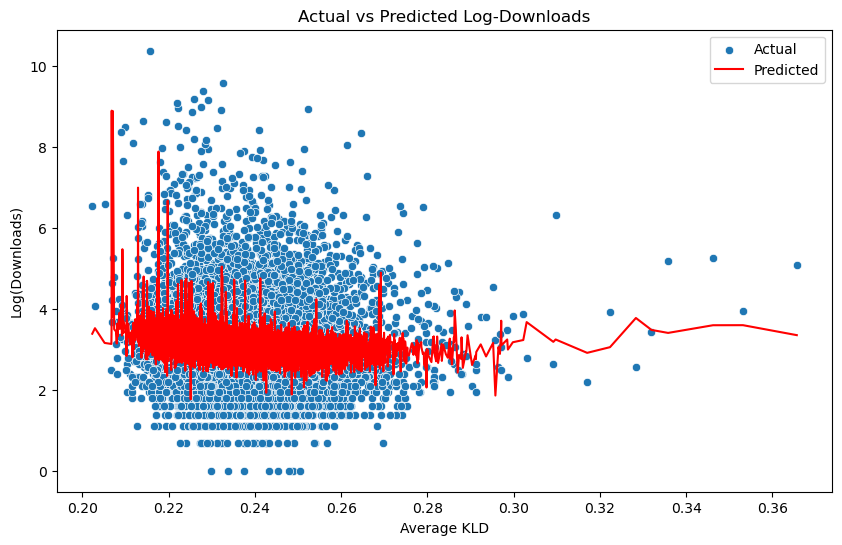

In [28]:
reg = LinearRegression().fit(X, y)
final_data.loc[X.index, 'predicted_log_downloads'] = reg.predict(X)

# Plot actual vs predicted log-downloads
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_kld', y='log_downloads', data=final_data, label='Actual')
sns.lineplot(x='avg_kld', y='predicted_log_downloads', data=final_data, color='red', label='Predicted')
plt.title('Actual vs Predicted Log-Downloads')
plt.xlabel('Average KLD')
plt.ylabel('Log(Downloads)')
plt.legend()
plt.show()

The blue scatter points represent the actual log-downloads for various books.
The red line represents the predicted log-downloads generated by the linear regression model.

Ideally, we would like the red line (predicted values) to closely follow the pattern of the blue points (actual values).
The spread of the blue points indicates the variability in the actual log-downloads at different average KLD values.

The red line (predicted values) is relatively flat compared to the spread of the blue points, suggesting that the model's predictions do not capture the full variability of the actual log-downloads.

The large discrepancies between the blue points and the red line suggest that the model might not be capturing all the relevant factors influencing log-downloads.

The flat nature of the red line could indicate that the average KLD has a limited predictive power in explaining the log-downloads alone, or that the linear model may not be fully appropriate for this relationship.

C:\Users\Zeeshan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Zeeshan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


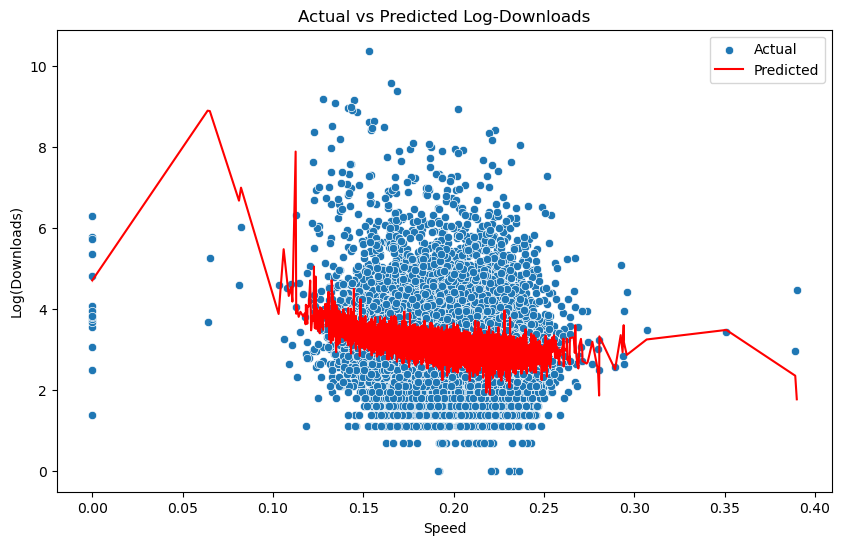

In [30]:
reg = LinearRegression().fit(X, y)
final_data.loc[X.index, 'predicted_log_downloads'] = reg.predict(X)

# Plot actual vs predicted log-downloads
plt.figure(figsize=(10, 6))
sns.scatterplot(x='speed', y='log_downloads', data=final_data, label='Actual')
sns.lineplot(x='speed', y='predicted_log_downloads', data=final_data, color='red', label='Predicted')
plt.title('Actual vs Predicted Log-Downloads')
plt.xlabel('Speed')
plt.ylabel('Log(Downloads)')
plt.legend()
plt.show()

The model's predictions (red line) capture the general trend of the actual data (blue dots) but show significant deviations, especially at lower and higher speed values.

The model may not fully capture the complexity of the relationship between speed and log-downloads, suggesting potential areas for improvement in the model.

The plot highlights that while speed has some predictive power, additional features or a more sophisticated model might be needed for better accuracy.

C:\Users\Zeeshan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Zeeshan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


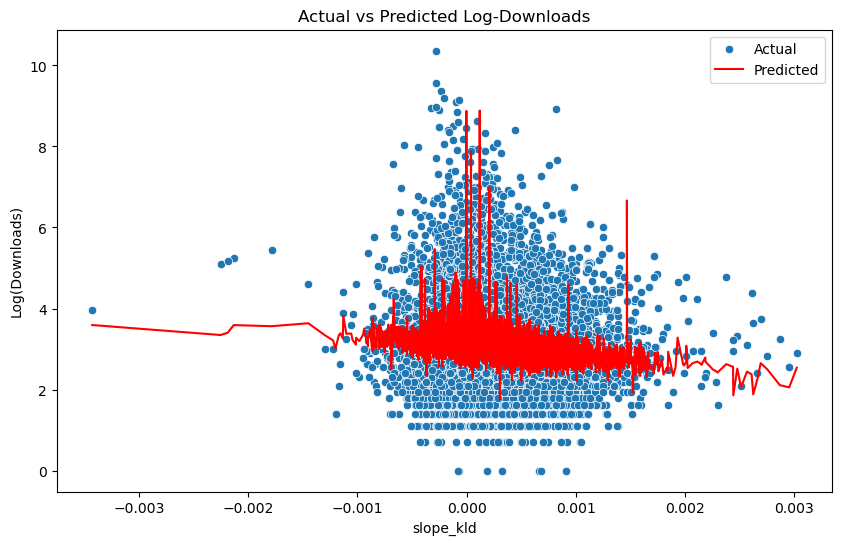

In [31]:
reg = LinearRegression().fit(X, y)
final_data.loc[X.index, 'predicted_log_downloads'] = reg.predict(X)

# Plot actual vs predicted log-downloads
plt.figure(figsize=(10, 6))
sns.scatterplot(x='slope_kld', y='log_downloads', data=final_data, label='Actual')
sns.lineplot(x='slope_kld', y='predicted_log_downloads', data=final_data, color='red', label='Predicted')
plt.title('Actual vs Predicted Log-Downloads')
plt.xlabel('slope_kld')
plt.ylabel('Log(Downloads)')
plt.legend()
plt.show()

The model may not fully capture the complexity of the relationship between slope_kld and log-downloads, suggesting potential areas for improvement in the model.

The plot highlights that while slope_kld has some predictive power, additional features or a more sophisticated model might be needed for better accuracy.

C:\Users\Zeeshan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Zeeshan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


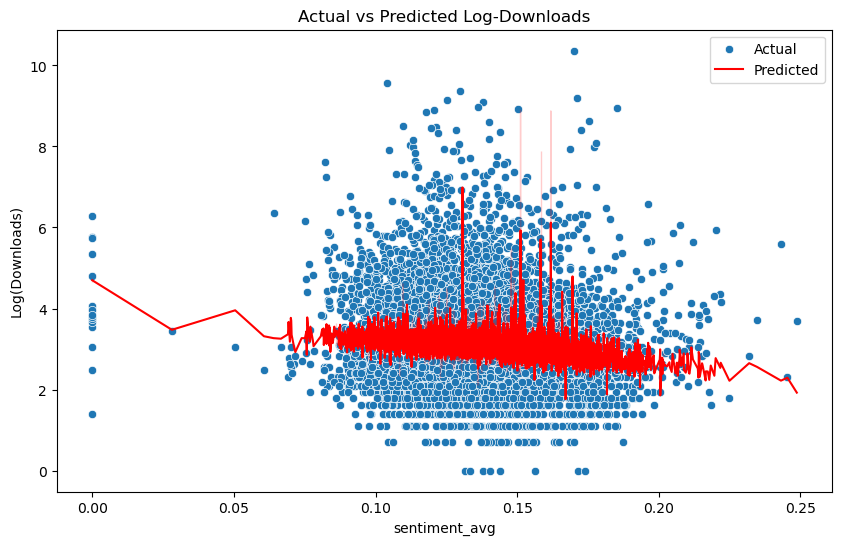

In [32]:
reg = LinearRegression().fit(X, y)
final_data.loc[X.index, 'predicted_log_downloads'] = reg.predict(X)

# Plot actual vs predicted log-downloads
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment_avg', y='log_downloads', data=final_data, label='Actual')
sns.lineplot(x='sentiment_avg', y='predicted_log_downloads', data=final_data, color='red', label='Predicted')
plt.title('Actual vs Predicted Log-Downloads')
plt.xlabel('sentiment_avg')
plt.ylabel('Log(Downloads)')
plt.legend()
plt.show()

C:\Users\Zeeshan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Zeeshan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


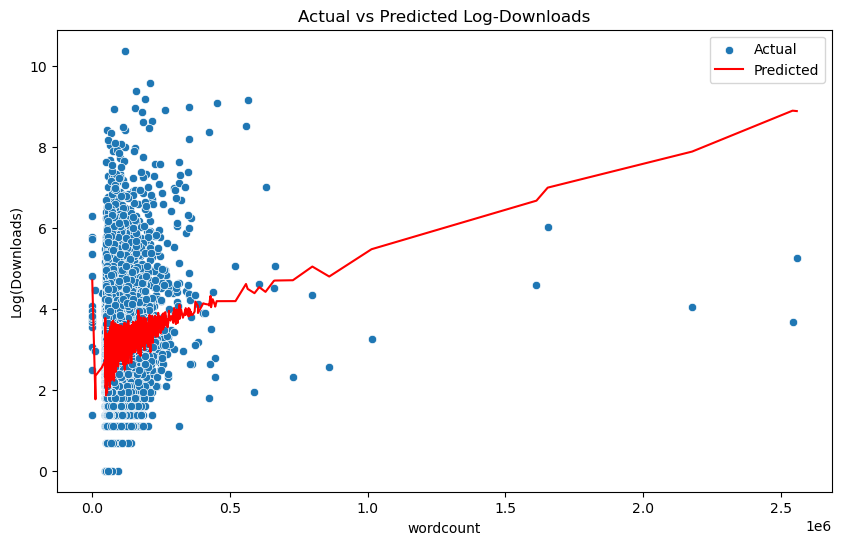

In [33]:
reg = LinearRegression().fit(X, y)
final_data.loc[X.index, 'predicted_log_downloads'] = reg.predict(X)

# Plot actual vs predicted log-downloads
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wordcount', y='log_downloads', data=final_data, label='Actual')
sns.lineplot(x='wordcount', y='predicted_log_downloads', data=final_data, color='red', label='Predicted')
plt.title('Actual vs Predicted Log-Downloads')
plt.xlabel('wordcount')
plt.ylabel('Log(Downloads)')
plt.legend()
plt.show()

The plot shows how the word count of books relates to their log-transformed download counts. The blue dots represent the actual download data, while the red line shows the model's predictions. The model suggests that books with higher word counts generally get more downloads. However, the actual data points vary a lot, especially for books with lower word counts, indicating that other factors might also influence downloads. The model captures the overall trend but could be improved to handle the variability better.

In this code chunk, we are analyzing the differences in how various factors affect book downloads across different genres. For each genre, we:

1. Filtered the data to include only books from that genre.
2. Skip the genre if it has fewer than 10 books to ensure we have enough data for reliable analysis.
3. Select the relevant features (KLD metrics, speed, sentiment, word count) for the analysis.
4. Add a constant term to the features for the regression model.

Perform a regression analysis to see how these features influence the log-transformed downloads within each genre.


In [29]:
# Investigate heterogeneity across genres
for col in subj2_columns:
    genre_data = final_data[final_data[col] == 1]
    if len(genre_data) < 10:  # Skip genres with less than 10 books
        continue
    
    X_genre = genre_data[['avg_kld', 'var_kld', 'slope_kld', 'skewness_kld', 'kurtosis_kld', 'num_peaks_kld', 'speed', 'sentiment_avg', 'wordcount']]
    y_genre = genre_data['log_downloads']
    
    # Add a constant term for the intercept
    X_genre = sm.add_constant(X_genre)
    
    # Perform regression analysis using statsmodels for detailed summary
    model_genre = sm.OLS(y_genre, X_genre).fit()
    print(f"Regression Results for Genre: {col}")
    print(model_genre.summary())
    print("\n")

Regression Results for Genre: subj2_war
                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     10.47
Date:                Tue, 02 Jul 2024   Prob (F-statistic):           3.98e-15
Time:                        20:37:49   Log-Likelihood:                -912.78
No. Observations:                 615   AIC:                             1846.
Df Residuals:                     605   BIC:                             1890.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const 

C:\Users\Zeeshan\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Regression Results for Genre: subj2_sciencefiction
                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     5.147
Date:                Tue, 02 Jul 2024   Prob (F-statistic):           2.72e-06
Time:                        20:37:49   Log-Likelihood:                -305.08
No. Observations:                 214   AIC:                             630.2
Df Residuals:                     204   BIC:                             663.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

Regression Results for Genre: subj2_periodicals
                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     12.37
Date:                Tue, 02 Jul 2024   Prob (F-statistic):           1.06e-15
Time:                        20:37:49   Log-Likelihood:                -275.42
No. Observations:                 222   AIC:                             570.8
Df Residuals:                     212   BIC:                             604.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

From the genre-specific regression analyses, several notable insights emerge:

Sentiment and Word Count:

Negative Impact of Sentiment: Across multiple genres such as War, Adventure, Fantasy, Science Fiction, and Mystery, a higher average sentiment (more positive tone) negatively impacts downloads. This suggests that books with a less positive tone may be more popular in these genres.

Positive Impact of Word Count: In genres like War, Adventure, Romance, Fantasy, Science Fiction, and History, a higher word count positively impacts downloads. This indicates that longer books tend to be more popular in these genres.


Genre-Specific Trends:

Romance and Slope KLD: In the Romance genre, a steeper slope in KLD (indicating a more pronounced trend or change in topic distribution over time) negatively impacts downloads. This could imply that readers prefer more consistent thematic development in Romance books.

Periodicals and KLD Features: For Periodicals, a higher average KLD positively impacts downloads, whereas higher variance in KLD negatively impacts downloads. This suggests that more diverse but less variable topic distributions are favored in Periodicals.

History and Skewness: In the History genre, higher skewness in KLD negatively impacts downloads, indicating that a more balanced topic distribution is preferred.


High R-squared in Crime Genre:

Crime Genre: The Crime genre shows a high R-squared value (0.696), suggesting that the model explains a significant portion of the variance in downloads. However, potential multicollinearity issues need to be considered. This genre's results are less interpretable due to the high condition number.


Impact of Speed:

Negative Impact in Multiple Genres: Speed negatively impacts downloads in genres like History and Others. This indicates that books with faster narrative pacing may be less popular in these genres.


Lack of Significant Predictors in Some Genres:

Biography, Drama, Western, and Horror: These genres do not show significant predictors, suggesting that factors influencing downloads in these categories may lie outside the scope of the analyzed features or that more data is needed to detect significant trends.


Mixed Impact of KLD Features:

Mixed Results: The impact of KLD-related features (average KLD, variance, slope, skewness, and kurtosis) varies across genres, with some showing significant effects while others do not. This variability underscores the complex relationship between topic distribution and book popularity.


In summary, these insights highlight the importance of genre-specific analyses when studying book downloads, as different factors play distinct roles in influencing popularity across various literary categories.

LASSO Regression Coefficients:
slope_kld              -0.027963
skewness_kld           -0.067621
speed                  -0.091361
sentiment_avg          -0.070917
wordcount               0.135704
subj2_romance           0.002781
subj2_fantasy           0.084700
subj2_sciencefiction    0.135289
subj2_horror            0.090778
subj2_mystery           0.020882
subj2_periodicals      -0.043603
subj2_others           -0.071516
dtype: float64


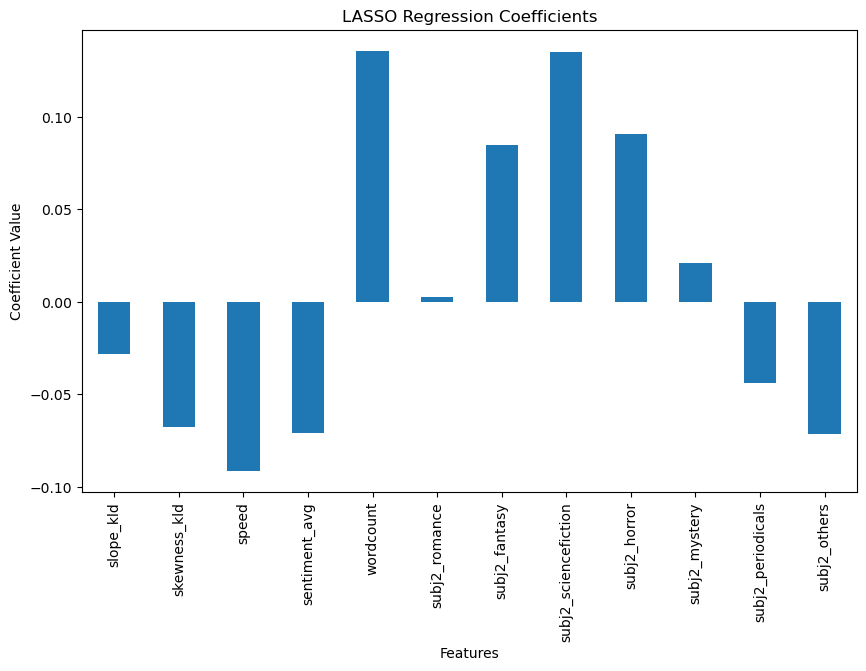

In [36]:
# Define the features and target variable
features = ['avg_kld', 'var_kld', 'slope_kld', 'skewness_kld', 'num_peaks_kld', 'speed', 'sentiment_avg', 'wordcount'] + [col for col in final_data.columns if col.startswith('subj2_')]
X = final_data[features]
y = final_data['log_downloads']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform LASSO regression with cross-validation to select the best alpha
lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)

# Display the coefficients
lasso_coefs = pd.Series(lasso.coef_, index=features)
print("LASSO Regression Coefficients:")
print(lasso_coefs[lasso_coefs != 0])  # Display only non-zero coefficients

# Plot the coefficients
plt.figure(figsize=(10, 6))
lasso_coefs[lasso_coefs != 0].plot(kind='bar')
plt.title('LASSO Regression Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()